In [12]:
!pip3 install numpy pandas matplotlib torch --quiet

In [9]:
import functions_for_thesis_display as f
from play_against_gpt import play_game
from setup import load_from_checkpoint
model = load_from_checkpoint()

/Users/rajenparekh/Desktop/Brown/2024-25/Senior Thesis/mnk_transformer/setup.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_loca

# Tic Tac GPT: Understanding a Transformer Trained on Tic Tac Toe

## Introduction

### How do we think about GPTs?
Your writing will be here.

### What are my research questions?
Your writing will be here.

### What concrete questions will we ask?
Your writing will be here.

In [10]:
play_game(model)

## Model Memorization vs Originality

We've seen above that the trained model can successfully play a game of tic-tac-toe. But how does it do that? Might it just be memorizing the games we showed it as it trained, and repeating them back exactly? This would be bad, especially when we think about language models! What if ChatGPT could only regurgitate exact writing that it had seen before? These models are only useful if they can generate novel games (or text!), so we test this capability.

To test the model's creativity, we train the model on 100,000 synthetically generated games of tic-tac-toe. These games are created by randomly choosing a move for players until one player wins or the board is filled. Then, once the model is trained, we ask it to generate 1,000 games and track how many of these games were included in the synthetic training dataset. We compute an originality score as follows.

$$
\text{Originality Score} = 1 - \frac{\text{\# of generated games present in training dataset}}{\text{total \# of games generated}}
$$

There are 255,168 possible games of Tic-Tac-Toe, so we would expect originality scores around<sup>[1]</sup>

$$
\frac{255,\!168 - 100,\!000}{255,\!168} \approx 60.8\%
$$



<p><sup>[1]</sup> <small><em>We would actually expect an originality score slightly higher than 60.8%, because the synthetic games are randomly generated, and can include overlapping games. A dataset with 100,000 elements is highly unlikely to have 100,000 distinct elements, but this is an expected floor for our originality score.</em></small></p>


## Learning the Rules of the Game

This section explores how the GPT model begins to pick up on the fundamental rules of tic tac toe through exposure to examples. We aim to understand whether the model is learning strategies or simply memorizing board states.

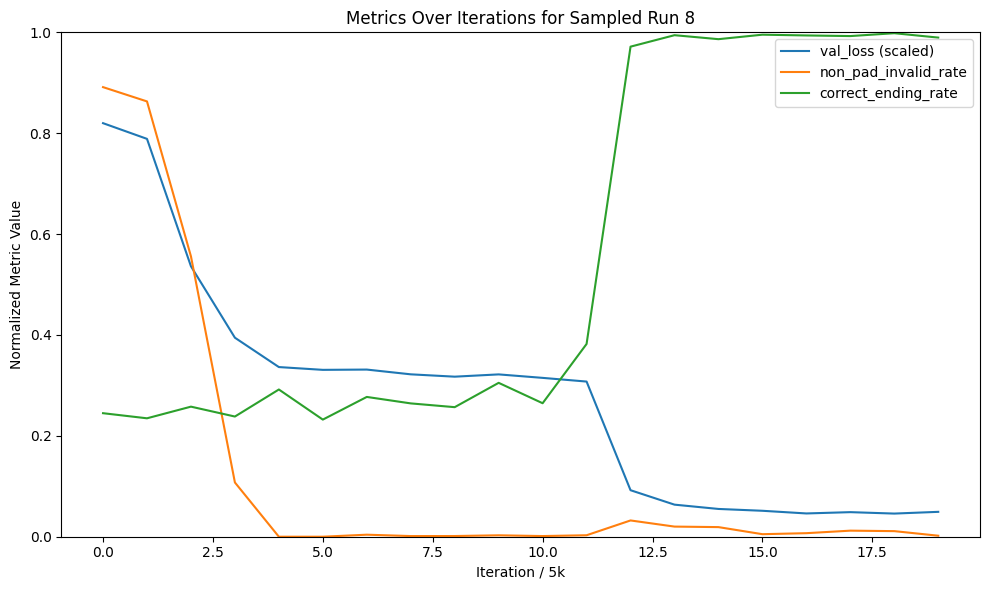

In [11]:
f.display_random_training_run()

## Internal Representation of the Game

### Different Tasks to Test
Your writing will be here.

### Linear vs. Nonlinear
Your writing will be here.


### Change in Number of Heads
Your writing will be here.

## Conclusion

### Summary of Findings
Your writing will be here.

### Future Work
Your writing will be here.

## Appendix

### Parameter Allocation
Your writing will be here.

### Math of GPT

$$
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{QK^T}{\sqrt{d_k}} \right)V
$$

### Mechanistic Interpretability Lit Review
Your writing will be here.